In [73]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import FunctionTransformer

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [106]:
df = pd.read_csv("../dataset.csv")
df.shape
columns_to_drop = []

In [107]:
# ---------------------------------
# Exploratory data analysis section
# ---------------------------------

In [108]:

df_copy = df.copy()

df_copy['TotalBath'] = df['Full Bath'] + 0.5 * df['Half Bath'] + .5 *  df['Bsmt Full Bath'] + .25* df['Bsmt Half Bath']
df_copy['Total Indoor SF'] = df['1st Flr SF'] + df['2nd Flr SF'] + df['Total Bsmt SF'] + df['Garage Area']

# Get skewness for all numeric columns
skew_values = df_copy.skew(numeric_only=True)

# Right skew (> 0.5) except for 
right_skewed = skew_values[skew_values > 0].drop(labels=['SalePrice'])

print("Right skewed columns (> 0.1):")
print(right_skewed.sort_values(ascending=False))

right_skewed_columns = right_skewed.index.tolist()

# Left skew (< -0.5)
left_skewed = skew_values[skew_values < -0.1]
print("\nLeft skewed columns (< -0.1):")
print(left_skewed.sort_values(ascending=True))  # Most negative first

left_skewed_columns = left_skewed.index.tolist()
print(left_skewed_columns)

Right skewed columns (> 0.1):
Misc Val           21.999788
Pool Area          16.939142
Lot Area           12.820898
Low Qual Fin SF    12.118162
3Ssn Porch         11.403795
Kitchen AbvGr       4.313825
BsmtFin SF 2        4.139978
Enclosed Porch      4.014446
Screen Porch        3.957467
Bsmt Half Bath      3.940795
Mas Vnr Area        2.606985
Open Porch SF       2.535386
Wood Deck SF        1.842678
Lot Frontage        1.499067
1st Flr SF          1.469429
BsmtFin SF 1        1.416182
MS SubClass         1.357579
Total Indoor SF     1.309545
Gr Liv Area         1.274110
Total Bsmt SF       1.156204
Bsmt Unf SF         0.923053
2nd Flr SF          0.866457
TotRms AbvGrd       0.753543
Fireplaces          0.739215
Half Bath           0.697713
Bsmt Full Bath      0.616639
Overall Cond        0.574429
TotalBath           0.418007
Bedroom AbvGr       0.305694
Garage Area         0.241994
Mo Sold             0.192596
Overall Qual        0.190634
Full Bath           0.171952
Yr Sold      

In [109]:
# Get correlations of all attributes
df_numerical = df.select_dtypes(include=[np.number])
corr = df_numerical.corr()

sale_price_corr = corr["SalePrice"].sort_values(key=abs, ascending=False)
print("Correlation:")
print(sale_price_corr)

low_corr_columns = sale_price_corr[abs(sale_price_corr) < 0.1].index.tolist()
high_corr_columns = sale_price_corr[abs(sale_price_corr) > 0.1].index.tolist()

print("Columns with correlation < 0.1:")

print(low_corr_columns)

# We will drop all columns with low correlation later
columns_to_drop += low_corr_columns
print("columns to drop:", columns_to_drop)


Correlation:
SalePrice          1.000000
Overall Qual       0.799262
Gr Liv Area        0.706780
Garage Cars        0.647877
Garage Area        0.640401
Total Bsmt SF      0.632280
1st Flr SF         0.621676
Year Built         0.558426
Full Bath          0.545604
Year Remod/Add     0.532974
Garage Yr Blt      0.526965
Mas Vnr Area       0.508285
TotRms AbvGrd      0.495474
Fireplaces         0.474558
BsmtFin SF 1       0.432914
Lot Frontage       0.357318
Wood Deck SF       0.327143
Open Porch SF      0.312951
Half Bath          0.285056
Bsmt Full Bath     0.276050
2nd Flr SF         0.269373
Lot Area           0.266549
PID               -0.246521
Bsmt Unf SF        0.182855
Bedroom AbvGr      0.143913
Enclosed Porch    -0.128787
Kitchen AbvGr     -0.119814
Screen Porch       0.112151
Overall Cond      -0.101697
MS SubClass       -0.085092
Pool Area          0.068403
Low Qual Fin SF   -0.037660
Bsmt Half Bath    -0.035835
Mo Sold            0.035259
3Ssn Porch         0.032225
Order  

In [116]:
corr_matrix = df.corr(numeric_only=True)
#fig, ax = plt.subplots(figsize=(20, 20))
# sns.heatmap(corr_matrix, ax=ax)
# From the heatmap we can see that garage area and garage cars are highly correlated
# Check:

df_garage = df[["Garage Cars", "Garage Area"]]
corr = df_garage.corr()
garage_cars_vs_area = corr.iloc[0, 1]
print(f"Correlation between Garage Cars and Garage Area: {garage_cars_vs_area:.3f}")

# We get a correlation of 0.89 between garage area and cars, so we will drop the garage cars column, too
columns_to_drop += ['Garage Cars']

print("columns to drop:", columns_to_drop)


Correlation between Garage Cars and Garage Area: 0.890
columns to drop: ['MS SubClass', 'Pool Area', 'Low Qual Fin SF', 'Bsmt Half Bath', 'Mo Sold', '3Ssn Porch', 'Order', 'Yr Sold', 'Misc Val', 'BsmtFin SF 2', 'Garage Cars', 'Garage Cars', 'Garage Cars', 'Garage Cars', 'Garage Cars', 'Garage Cars', 'Garage Cars']


In [91]:
# Print out all columns with less than len(df) non-null values
null_counts = df.isnull().sum() 

non_null_counts = len(df) - null_counts
cols_with_missing = non_null_counts[non_null_counts < len(df)]

# Which of the highly correlated features have missing entries? Use intersect:
common_columns = list(set(cols_with_missing.index) & set(high_corr_columns))
print("\nColumns in common:")
print(common_columns)

for col in common_columns:
    print(f"{col}: {null_counts[col]} missing")

# We can see that there are 490 missing values for lot frontage and 159 for Garage Yr Blt. 
# 490 is 16%, so we could potentially drop that column, but for now we will just impute the median.
# But for the Garage Yr Blt feature, adding the age of the house is a pretty good estimate.
# For the rest, we can safely impute the median.

print("columns to drop:", columns_to_drop)



Columns in common:
['Garage Cars', 'BsmtFin SF 1', 'Lot Frontage', 'Total Bsmt SF', 'Mas Vnr Area', 'Bsmt Full Bath', 'Garage Yr Blt', 'Bsmt Unf SF', 'Garage Area']
Garage Cars: 1 missing
BsmtFin SF 1: 1 missing
Lot Frontage: 490 missing
Total Bsmt SF: 1 missing
Mas Vnr Area: 23 missing
Bsmt Full Bath: 2 missing
Garage Yr Blt: 159 missing
Bsmt Unf SF: 1 missing
Garage Area: 1 missing
columns to drop: ['MS SubClass', 'Pool Area', 'Low Qual Fin SF', 'Bsmt Half Bath', 'Mo Sold', '3Ssn Porch', 'Order', 'Yr Sold', 'Misc Val', 'BsmtFin SF 2', 'Garage Cars']


In [92]:
# ---------------------------------
# Start building the model
# ---------------------------------

In [ ]:
# Drop columns we don't want for the model
print("Columns in df after dropping:")
print(df.columns)

needed_for_pipeline = ["Full Bath", "Half Bath", "Bsmt Full Bath", "Bsmt Half Bath", # For Total Indoor SF
                       "Garage Yr Blt", "Year Built", # For imputing garage year built
                       "1st Flr SF", "2nd Flr SF", "Total Bsmt SF", "Garage Area"] # 
columns_to_drop = list(set(columns_to_drop) - set(needed_for_pipeline))
print("columns to drop:", columns_to_drop)
df = df.drop(columns=(columns_to_drop), axis=1)

print("Columns in df after dropping:")
print(df.columns)

In [ ]:
# Make training/test-set using sale price category as the stratifying variable
df['Sale Price Category'] = pd.qcut(df['SalePrice'], 
                                    q=5,
                                    labels = [0, 1, 2, 3, 4],
                                    duplicates='drop')

strat_train_set, strat_test_set = train_test_split(df, stratify=df['Sale Price Category'], random_state=42)

 # Drop info about sales price from df
strat_train_set = strat_train_set.drop(columns=['Sale Price Category'])
strat_test_set = strat_test_set.drop(columns=['Sale Price Category'])

# Verify that the stratified set is as representative as the entire training set
print("ratios in housing set")
print(df['Sale Price Category'].value_counts() / len(df))

print("ratios in stratified set")
print(strat_test_set['Sale Price Category'].value_counts() / len(strat_test_set))

ratios in housing set
Sale Price Category
0    0.203413
3    0.202389
2    0.198635
1    0.197952
4    0.197611
Name: count, dtype: float64
ratios in stratified set
Sale Price Category
0    0.203274
3    0.201910
2    0.199181
1    0.197817
4    0.197817
Name: count, dtype: float64


In [ ]:
# Make sure right_skewed and left_skewed column lists don't include any of the features we have removed (it gets used in the column transformer)
right_skewed_columns = list(set(right_skewed_columns) & set(df.columns))
left_skewed_columns = list(set(left_skewed_columns) & set(df.columns))

df_predictors = strat_train_set.drop('SalePrice', axis=1)
df_labels = strat_train_set['SalePrice'].copy()

df_categorical = df_predictors.select_dtypes(include=[object])


cat_pipeline = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='unknown'),
    OneHotEncoder(handle_unknown='ignore')
)

log_num_pipeline = make_pipeline(SimpleImputer(strategy='median'),
                                 FunctionTransformer(np.log1p),
                                 StandardScaler())


def flip_and_log(X):
    X = np.asarray(X)
    max_year = X.max()
    return np.log1p(max_year - X)


flip_and_log_pipeline = make_pipeline(SimpleImputer(strategy='median'),
                                 FunctionTransformer(flip_and_log),
                                 StandardScaler())

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
)

# --- TotalBath ---
def total_bath(X):
    X = np.asarray(X)
    # Assumes order: Full Bath, Half Bath, Bsmt Full Bath, Bsmt Half Bath
    return (X[:, [0]] 
            + 0.5 * X[:, [1]] 
            + 0.5 * X[:, [2]] 
            + 0.25 * X[:, [3]]).reshape(-1, 1)

def total_bath_name(transformer, feature_names_in):
    return ["Total Bath"]

# Pipeline for TotalBath
def total_bath_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(total_bath, feature_names_out=total_bath_name),
        StandardScaler()
    )

# --- Total Indoor SF ---
def total_indoor_sf(X):
    X = np.asarray(X)
    # Assumes order: 1st Flr SF, 2nd Flr SF, Total Bsmt SF, Garage Area
    return (X[:, 0] + X[:, 1] + X[:, 2] + X[:, 3]).reshape(-1, 1)

def total_indoor_sf_name(transformer, feature_names_in):
    return ["Total Indoor SF"]

# Pipeline for Total Indoor SF
def total_indoor_sf_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(total_indoor_sf, feature_names_out=total_indoor_sf_name),
        StandardScaler()
    )

# Replaces garage year built NaN entries with its corresponding house Year Built
def impute_garage_year(X):
    X = np.asarray(X)
    X = X.copy()
    mask = np.isnan(X[:, 0])
    X[mask, 0] = X[mask, 1]
    return X[:, [0]]


def garage_year_built_pipeline():
    return make_pipeline(
        FunctionTransformer(impute_garage_year),
        StandardScaler()
    )


preprocessing = ColumnTransformer([
    ("total_bath", total_bath_pipeline(), ["Full Bath", "Half Bath", "Bsmt Full Bath", "Bsmt Half Bath"]),
    ("total_indoor_sf", total_indoor_sf_pipeline(), ["1st Flr SF", "2nd Flr SF", "Total Bsmt SF", "Garage Area"]),
    ('garage_year_built_pipeline', garage_year_built_pipeline(), ["Garage Yr Blt", "Year Built"]),
    ('cat', cat_pipeline, df_categorical.columns),
    ('log_num', log_num_pipeline, right_skewed_columns),
    ('flip_and_log', flip_and_log_pipeline, left_skewed_columns)
],
remainder=default_num_pipeline)  # or your default_num_pipeline

In [132]:
print(df_predictors.shape)
print(df_labels.shape)

print("")
pd.set_option('display.width', None) 
print(df_predictors.columns)


(2197, 72)
(2197,)

Index(['PID', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street', 'Alley',
       'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope',
       'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'Bsmt Unf SF',
       'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air', 'Electrical',
       '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'Garage Finish', 'Garage Area', 'Garage Qual'

In [ ]:
from sklearn.model_selection import cross_val_score, KFold

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(df_predictors, df_labels)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
lin_reg_rmse = -cross_val_score(lin_reg, df_predictors, df_labels, scoring="neg_root_mean_squared_error", cv=kf)

pd.Series(lin_reg_rmse).describe()

count        5.000000
mean    -28244.670150
std       5154.462818
min     -36109.176162
25%     -30503.883873
50%     -26638.154795
75%     -24469.374030
max     -23502.761890
dtype: float64

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly_reg = make_pipeline(preprocessing, PolynomialFeatures(degree=2), LinearRegression())
poly_reg.fit(df_predictors, df_labels)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
poly_reg_rmse = -cross_val_score(poly_reg, df_predictors, df_labels, scoring="neg_root_mean_squared_error", cv=kf)

pd.Series(poly_reg_rmse).describe()

count        5.000000
mean    -30122.750672
std       2755.693026
min     -33143.113810
25%     -31527.246392
50%     -31288.407789
75%     -28398.586415
max     -26256.398954
dtype: float64

In [127]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(df_predictors, df_labels)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
tree_reg_rmse = -cross_val_score(tree_reg, df_predictors, df_labels, scoring="neg_root_mean_squared_error", cv=kf)

pd.Series(tree_reg_rmse).describe()

count        5.000000
mean     26371.586056
std       2806.603623
min      23799.096977
25%      25464.486309
50%      25540.385677
75%      25873.189060
max      31180.772259
dtype: float64

In [131]:
# Training error for linear regression model
train_predictions = lin_reg.predict(df_predictors)
train_rmse = root_mean_squared_error(df_labels, train_predictions)
print("Training RMSE for lin_reg:", train_rmse)

# Training error for polynomial model
train_predictions = poly_reg.predict(df_predictors)
train_rmse = root_mean_squared_error(df_labels, train_predictions)
print("Training RMSE for poly_reg:", train_rmse)

# Training error decision tree regressor model
train_predictions = tree_reg.predict(df_predictors)
train_rmse = root_mean_squared_error(df_labels, train_predictions)
print("Training RMSE for tree_reg:", train_rmse)


Training RMSE for lin_reg: 20019.926236877644
Training RMSE for poly_reg: 119.34389606078089
Training RMSE for tree_reg: 60.34342619636432


In [ ]:

df_predictions = lin_reg.predict(df_predictors)
print(df_predictions[0:25].round(-2))
print(df_labels.iloc[0:25].values)
print("Difference in prediction vs reality: ", df_predictions[0:25].round(-2)-df_labels.iloc[0:25].values)

lin_rmse = root_mean_squared_error(df_labels, df_predictions)
print(lin_rmse)

mae = mean_absolute_error(df_labels, df_predictions)
print(mae)


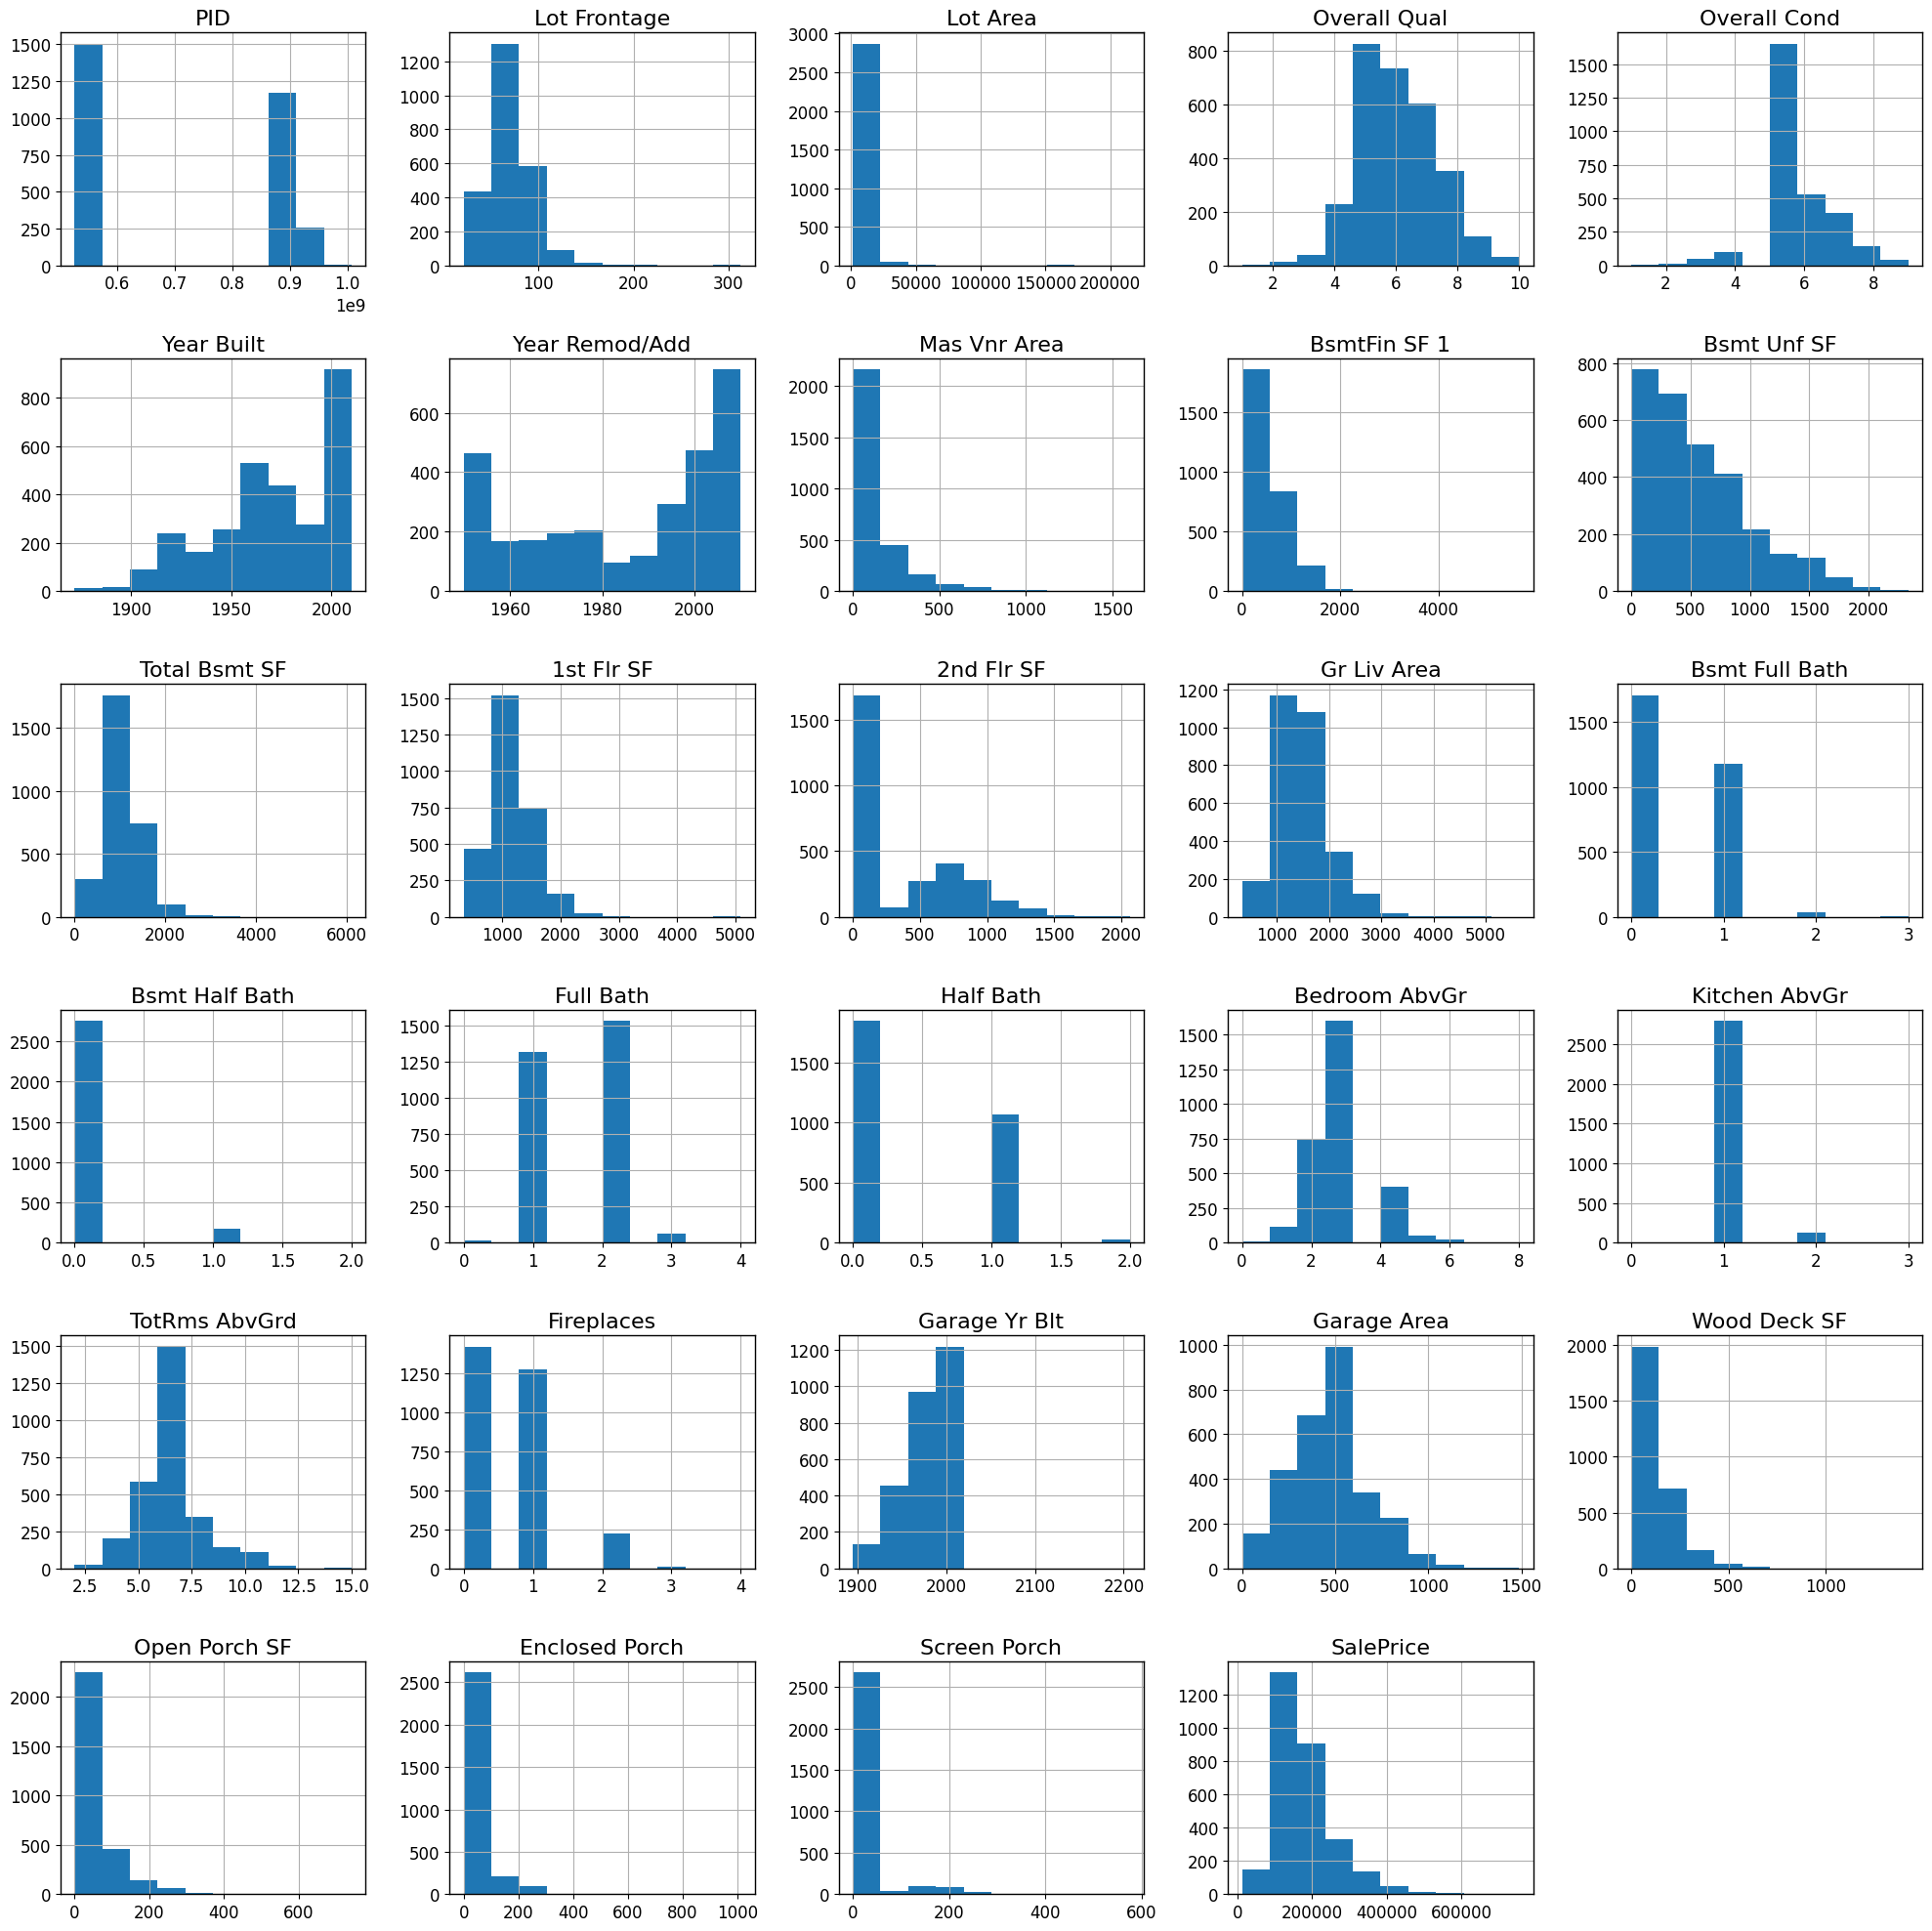

In [104]:
df.select_dtypes(include=[np.number]).hist(figsize=(20, 20));


In [152]:

corr = df_numerical.corr()

# fig, ax = plt.subplots(figsize=(20, 20))
#sns.heatmap(corr, ax=ax)

print(corr["SalePrice"].sort_values(key=abs, ascending=False))

SalePrice          1.000000
Total Indoor SF    0.821317
Overall Qual       0.799262
Gr Liv Area        0.706780
TotalBath          0.650040
Garage Cars        0.647877
Garage Area        0.640401
Total Bsmt SF      0.632280
1st Flr SF         0.621676
Year Built         0.558426
Full Bath          0.545604
Year Remod/Add     0.532974
Garage Yr Blt      0.526965
Mas Vnr Area       0.508285
TotRms AbvGrd      0.495474
Fireplaces         0.474558
BsmtFin SF 1       0.432914
Lot Frontage       0.357318
Wood Deck SF       0.327143
Open Porch SF      0.312951
Half Bath          0.285056
Bsmt Full Bath     0.276050
2nd Flr SF         0.269373
Lot Area           0.266549
PID               -0.246521
Bsmt Unf SF        0.182855
Bedroom AbvGr      0.143913
Enclosed Porch    -0.128787
Kitchen AbvGr     -0.119814
Screen Porch       0.112151
Overall Cond      -0.101697
MS SubClass       -0.085092
Pool Area          0.068403
Low Qual Fin SF   -0.037660
Bsmt Half Bath    -0.035835
Mo Sold            0

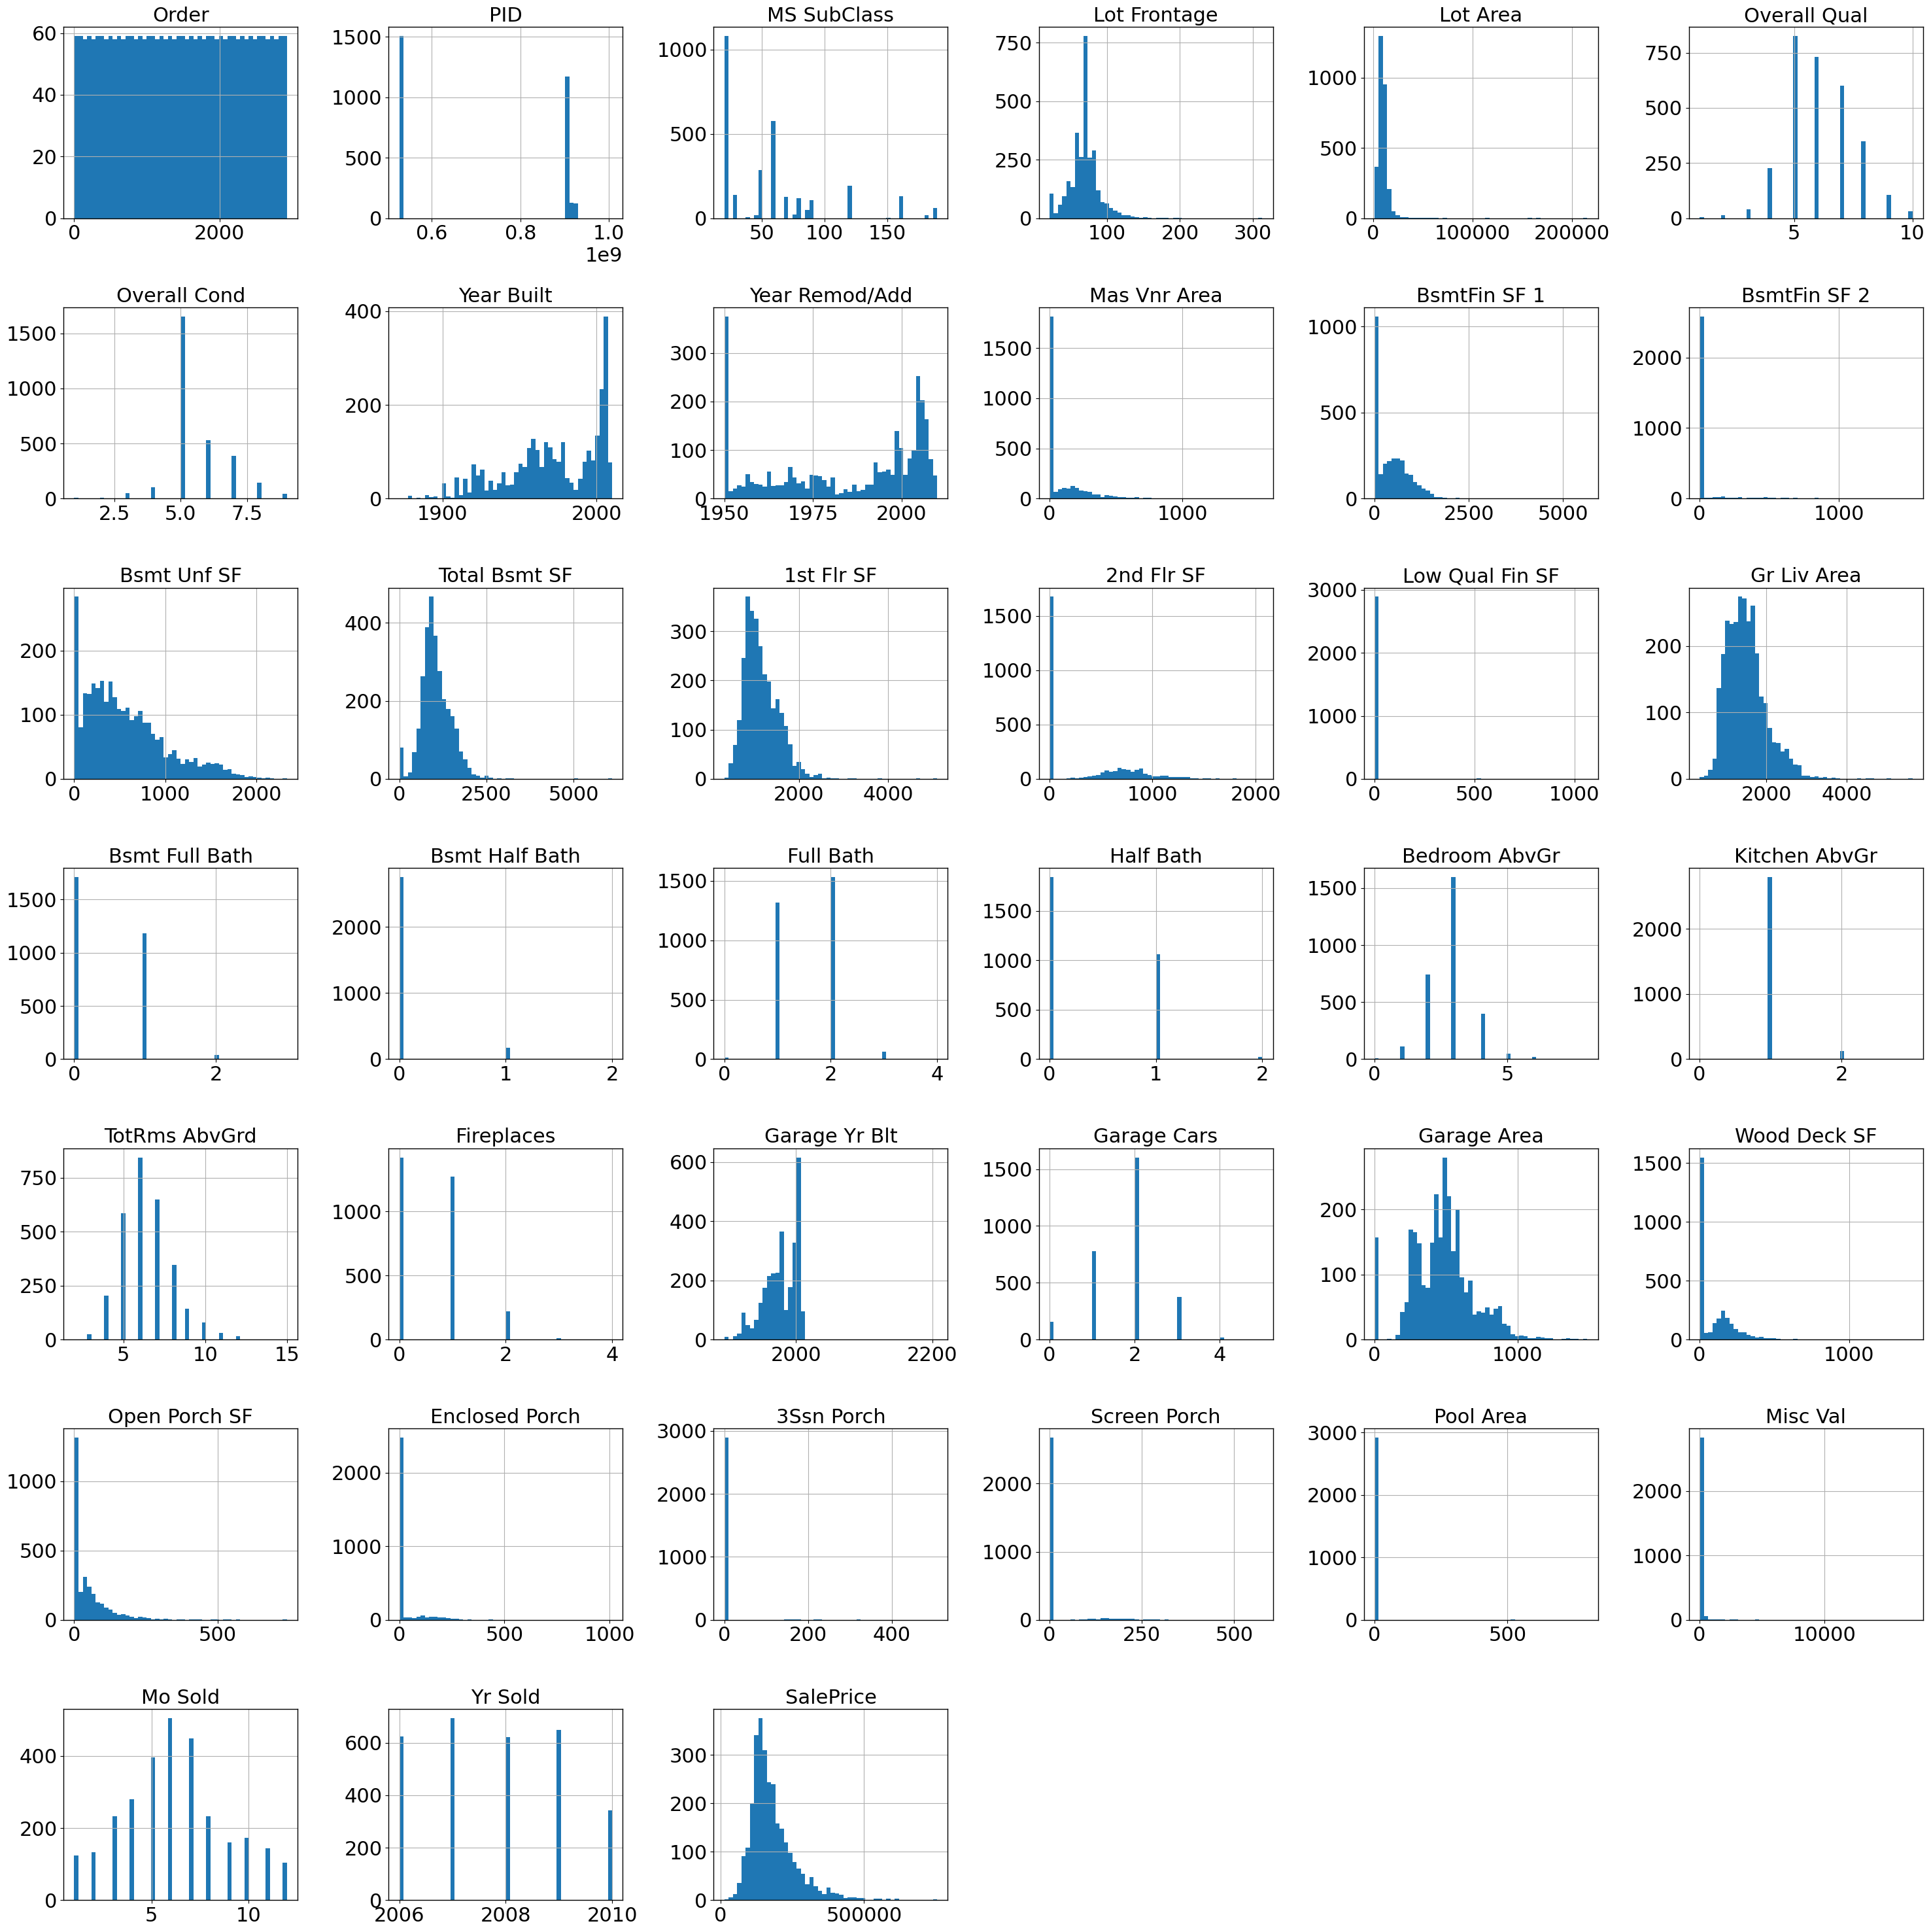

In [ ]:
df_numerical_clean.hist(bins=50, figsize=(30, 30));

ModuleNotFoundError: No module named 'pandas.core.methods.to_dict'

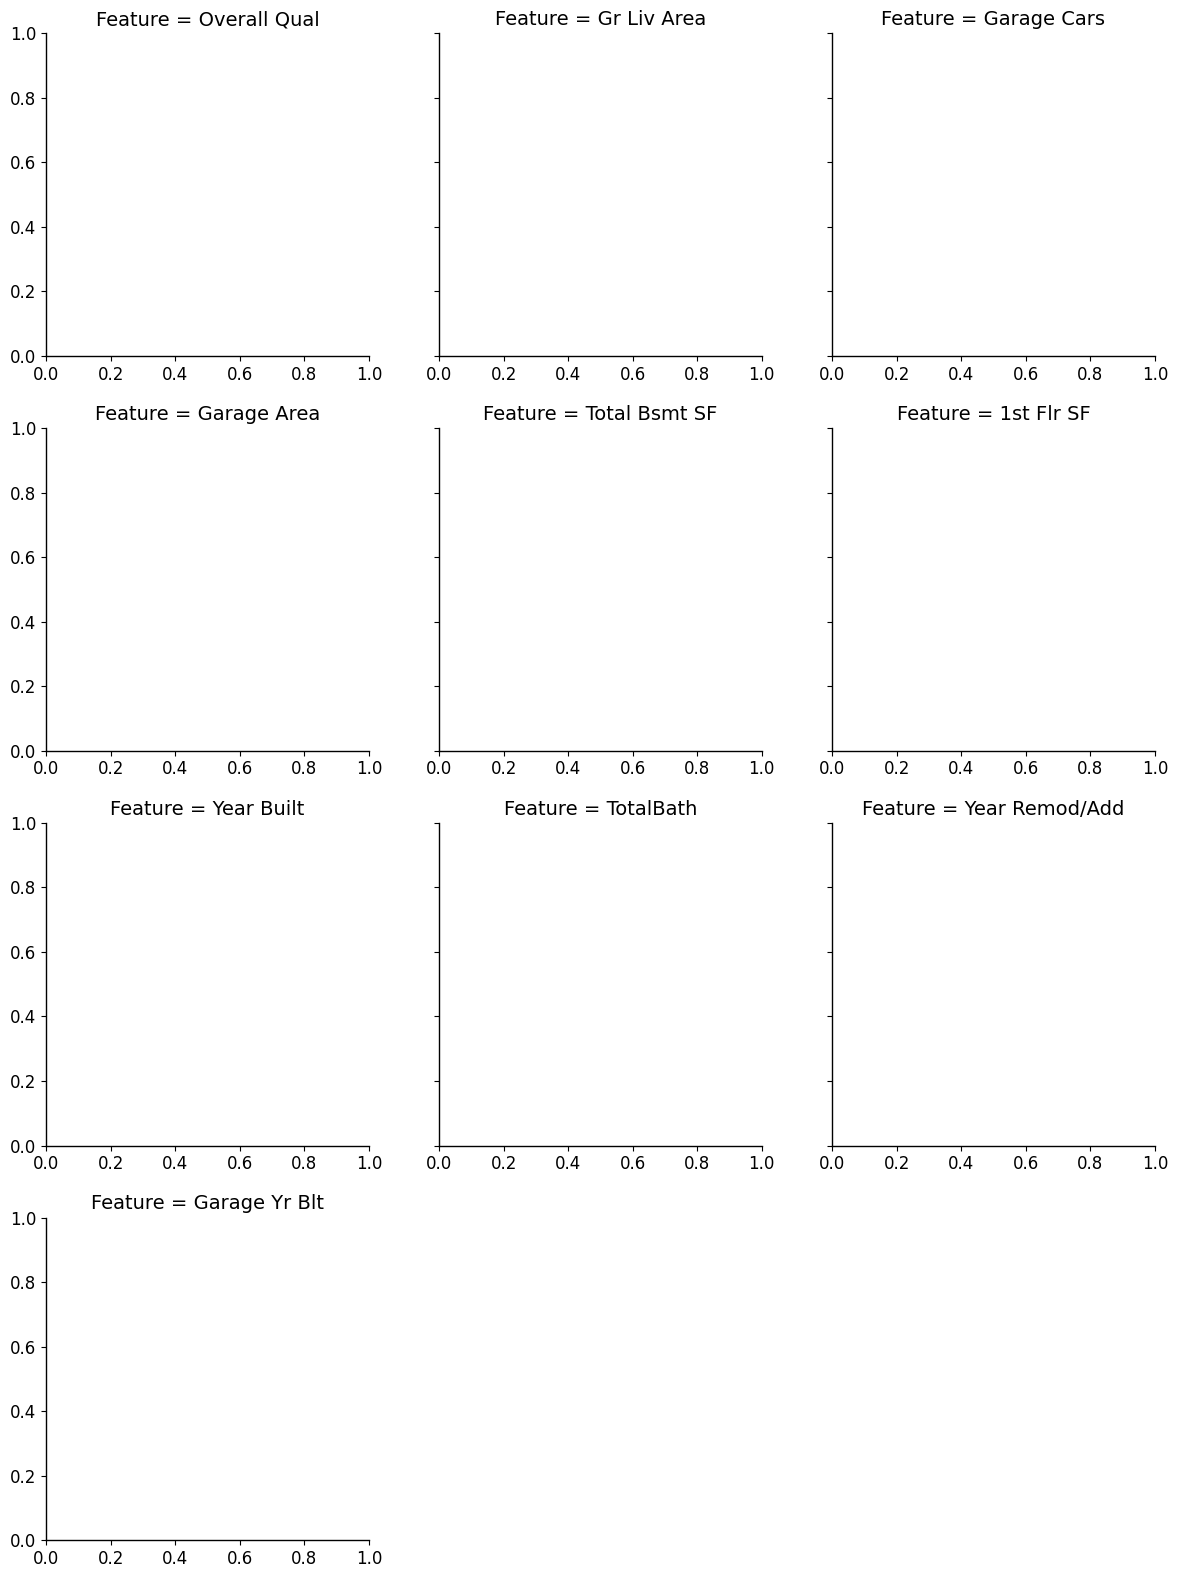

In [36]:
# Scatter plots to figure out what data needs to be cleaned

corr = df.select_dtypes(include=[np.number]).corr()

att = ["Overall Qual",
       "Gr Liv Area",
       "Garage Cars",
       "Garage Area",
       "Total Bsmt SF",
       "1st Flr SF",
       "Year Built",
       "TotalBath",
       "Year Remod/Add",
       "Garage Yr Blt"]

df_melt = df.melt(id_vars='SalePrice', value_vars=att,
                  var_name='Feature', value_name='Value')

# Horizontal layout with 3 plots per row
g = sns.FacetGrid(df_melt, col='Feature', col_wrap=3, height=4, sharex=False, sharey=True)
g.map_dataframe(sns.scatterplot, x='Value', y='SalePrice', s=20)
g.set_axis_labels("", "SalePrice")
plt.tight_layout()
plt.show()

In [37]:
df['TotalBath'] = df['Full Bath'] + 0.5 * df['Half Bath'] + .5 *  df['Bsmt Full Bath'] + .25* df['Bsmt Half Bath']
df['Total Indoor SF'] = df['1st Flr SF'] + df['2nd Flr SF'] + df['Total Bsmt SF'] + df['Garage Area']

corrmatrix = df[['TotalBath', 'SalePrice']].corr()
print(corrmatrix)
corrmatrix = df[['Total Indoor SF', 'SalePrice']].corr()
print(corrmatrix)

df[['TotalBath', 'Total Indoor SF']].head()



ModuleNotFoundError: No module named 'pandas.io.formats.string'

In [38]:
# Get correlations of all attributes
df_numerical = df.select_dtypes(include=[np.number])
corr = df_numerical.corr()

sale_price_corr = corr["SalePrice"].sort_values(key=abs, ascending=False)
print("Correlation:")
print(sale_price_corr)

low_corr_columns = sale_price_corr[abs(sale_price_corr) > 0.25].index.tolist()


# fig, ax = plt.subplots(figsize=(20, 20))
#sns.heatmap(corr, ax=ax)

print("Columns with correlation > 0.25:")

print(low_corr_columns)

Correlation:
SalePrice          1.000000
Total Indoor SF    0.821317
Overall Qual       0.799262
Gr Liv Area        0.706780
TotalBath          0.650040
Garage Cars        0.647877
Garage Area        0.640401
Total Bsmt SF      0.632280
1st Flr SF         0.621676
Year Built         0.558426
Full Bath          0.545604
Year Remod/Add     0.532974
Garage Yr Blt      0.526965
Mas Vnr Area       0.508285
TotRms AbvGrd      0.495474
Fireplaces         0.474558
BsmtFin SF 1       0.432914
Lot Frontage       0.357318
Wood Deck SF       0.327143
Open Porch SF      0.312951
Half Bath          0.285056
Bsmt Full Bath     0.276050
2nd Flr SF         0.269373
Lot Area           0.266549
PID               -0.246521
Bsmt Unf SF        0.182855
Bedroom AbvGr      0.143913
Enclosed Porch    -0.128787
Kitchen AbvGr     -0.119814
Screen Porch       0.112151
Overall Cond      -0.101697
MS SubClass       -0.085092
Pool Area          0.068403
Low Qual Fin SF   -0.037660
Bsmt Half Bath    -0.035835
Mo Sold

In [40]:

# Print out all columns with less than len(df) non-null values
null_counts = df.isnull().sum() 

non_null_counts = len(df) - null_counts
cols_with_missing = non_null_counts[non_null_counts < len(df)]

print('Columns with missing values:')
print(cols_with_missing)

Columns with missing values:
Lot Frontage       2440
Alley               198
Mas Vnr Type       1155
Mas Vnr Area       2907
Bsmt Qual          2850
Bsmt Cond          2850
Bsmt Exposure      2847
BsmtFin Type 1     2850
BsmtFin SF 1       2929
BsmtFin Type 2     2849
BsmtFin SF 2       2929
Bsmt Unf SF        2929
Total Bsmt SF      2929
Electrical         2929
Bsmt Full Bath     2928
Bsmt Half Bath     2928
Fireplace Qu       1508
Garage Type        2773
Garage Yr Blt      2771
Garage Finish      2771
Garage Cars        2929
Garage Area        2929
Garage Qual        2771
Garage Cond        2771
Pool QC              13
Fence               572
Misc Feature        106
TotalBath          2928
Total Indoor SF    2928
dtype: int64
